In [1]:
import pyreadr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
result = pyreadr.read_r("data/atsp_spring.rds")

In [3]:
df = list(result.values())[0]

In [4]:
df.head()

runID                            ts   tsCorrected      sig    sigsd  \
0  253470629 2019-04-18 02:43:52.837699890  1.555573e+09 -69.9975  42.9432   
1  253470629 2019-04-18 02:44:12.536200047  1.555573e+09 -72.4903  61.8822   
2  253470629 2019-04-18 02:44:32.224400043  1.555573e+09 -68.8146  29.5234   
3  253470629 2019-04-18 02:44:51.924200058  1.555573e+09 -69.2750  21.6095   
4  253470629 2019-04-18 02:45:11.622900009  1.555574e+09 -65.2469  24.5274   

     noise    freq  freqsd  motusTagID ambigID  ... Sex  Location  BandNumber  \
0 -79.0219  4.2485  0.0276     32463.0     NaN  ...   U   OLD CUT  2720-19140   
1 -80.2089  4.2523  0.0068     32463.0     NaN  ...   U   OLD CUT  2720-19140   
2 -77.9249  4.2648  0.0136     32463.0     NaN  ...   U   OLD CUT  2720-19140   
3 -78.3453  4.2630  0.0089     32463.0     NaN  ...   U   OLD CUT  2720-19140   
4 -78.2161  4.2637  0.0055     32463.0     NaN  ...   U   OLD CUT  2720-19140   

  Wing Fat  Mass  Lost Isotope_value  captureDate  capture.yday  
0   77   4  22.0     0           NaN   2019-02-27          58.0  
1   77   4  22.0     0           NaN   2019-02-27          58.0  
2   77   4  22.0     0           NaN   2019-02-27          58.0  
3   77   4  22.0     0           NaN   2019-02-27          58.0  
4   77   4  22.0     0           NaN   2019-02-27          58.0  

[5 rows x 50 columns]

In [5]:
df.columns

Index(['runID', 'ts', 'tsCorrected', 'sig', 'sigsd', 'noise', 'freq', 'freqsd',
       'motusTagID', 'ambigID', 'port', 'runLen', 'motusFilter', 'mfgID',
       'tagModel', 'tagLifespan', 'tagBI', 'tagDeployID', 'markerNumber',
       'tagDeployStart', 'tagDeployEnd', 'tagDepLat', 'tagDepLon', 'tagDepAlt',
       'recvDeployLat', 'recvDeployLon', 'recvDeployName', 'antBearing',
       'ts_5min', 'date', 'year', 'yday', 'month', 'day', 'minute', 'hour',
       'sunrise', 'sunset', 'tagYear', 'Age', 'Sex', 'Location', 'BandNumber',
       'Wing', 'Fat', 'Mass', 'Lost', 'Isotope_value', 'captureDate',
       'capture.yday'],
      dtype='object')

In [6]:
df['ts'] = pd.to_datetime(df['ts'])
df['captureDate'] = pd.to_datetime(df['captureDate'])

In [7]:
df['bird_id'] = df['BandNumber'].astype(str) + "_" + df['motusTagID'].astype(int).astype(str)

In [8]:
df.columns

Index(['runID', 'ts', 'tsCorrected', 'sig', 'sigsd', 'noise', 'freq', 'freqsd',
       'motusTagID', 'ambigID', 'port', 'runLen', 'motusFilter', 'mfgID',
       'tagModel', 'tagLifespan', 'tagBI', 'tagDeployID', 'markerNumber',
       'tagDeployStart', 'tagDeployEnd', 'tagDepLat', 'tagDepLon', 'tagDepAlt',
       'recvDeployLat', 'recvDeployLon', 'recvDeployName', 'antBearing',
       'ts_5min', 'date', 'year', 'yday', 'month', 'day', 'minute', 'hour',
       'sunrise', 'sunset', 'tagYear', 'Age', 'Sex', 'Location', 'BandNumber',
       'Wing', 'Fat', 'Mass', 'Lost', 'Isotope_value', 'captureDate',
       'capture.yday', 'bird_id'],
      dtype='object')

In [9]:
detections_per_day = (
    df.groupby(['bird_id', 'date'])
      .size()
      .reset_index(name='n_detections')
)

In [10]:
detections_per_day

bird_id        date  n_detections
0     2221-38875_43401  2020-01-17          1705
1     2221-38875_43401  2020-01-18          2988
2     2221-38875_43401  2020-01-19          4337
3     2221-38875_43401  2020-01-20          3432
4     2221-38875_43401  2020-01-21          3318
...                ...         ...           ...
2941        UNK2_43376  2020-03-27           975
2942        UNK2_43376  2020-03-28          2007
2943        UNK2_43376  2020-03-29           626
2944        UNK2_43376  2020-03-30            48
2945        UNK2_43376  2020-04-01            13

[2946 rows x 3 columns]

In [11]:

# Si 'date' es string:
df['date'] = pd.to_datetime(df['date']).dt.date

# Minuto del día (0–1439)
df['minute_of_day'] = df['hour'] * 60 + df['minute']

In [12]:
def plot_day_antennas_full(df, bird_id, day, show_sun=True):
    """
    Muestra TODAS las antenas (estación+port) que detectan a un individuo ese día.
    Cada color = una antena única (receiver + port).
    """
    day = pd.to_datetime(day).date()

    # Filtrar por individuo y día
    d = df[(df['bird_id'] == bird_id) & (df['date'] == day)].copy()
    if d.empty:
        print("No detections for this bird on this date.")
        return

    # Minuto del día
    if 'minute_of_day' not in d.columns:
        d['minute_of_day'] = d['hour'] * 60 + d['minute']

    # === Crear ID único de antena: estacion + port (y opcionalmente bearing) ===
    d['antenna_id'] = (
        d['recvDeployName'].astype(str)
        + " | P" + d['port'].astype(int).astype(str)
        # + " | " + d['antBearing'].astype(int).astype(str) + "°"  # <- si quieres incluir bearing
    )

    antennas = sorted(d['antenna_id'].dropna().unique())

    # Colores para cada antena única
    cmap = plt.cm.get_cmap('tab20', len(antennas))

    plt.figure(figsize=(12, 5))

    for i, ant in enumerate(antennas):
        sub = d[d['antenna_id'] == ant]
        plt.scatter(
            sub['minute_of_day'],
            sub['sig'],
            s=15,
            alpha=0.7,
            label=ant,
            color=cmap(i)
        )

    # Amanecer / atardecer
    if show_sun:
        try:
            sunrise = pd.to_datetime(d['sunrise'].iloc[0])
            sunset  = pd.to_datetime(d['sunset'].iloc[0])
            sr_min = sunrise.hour * 60 + sunrise.minute
            ss_min = sunset.hour * 60 + sunset.minute
            plt.axvline(sr_min, linestyle='--', alpha=0.6)
            plt.axvline(ss_min, linestyle='--', alpha=0.6)
        except Exception as e:
            print("Could not add sunrise/sunset lines:", e)


    #plt.gca().invert_yaxis()
    plt.xlim(0, 1440)
    plt.xlabel("Minute of day")
    plt.ylabel("Signal strength (sig)")
    plt.title(f"Signal by antenna for {bird_id} on {day}")


    plt.legend(title="Antenna (station | port)",
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()


In [13]:
all_ids = sorted(df['bird_id'].dropna().unique())
all_ids[:50]  # ver los primeros 10

['2221-38875_43401',
 '2221-38877_43404',
 '2221-38878_43403',
 '2221-38880_43407',
 '2221-38882_43406',
 '2221-38883_43405',
 '2221-38884_43409',
 '2221-38886_43408',
 '2710-62970_32462',
 '2720-19060_32481',
 '2720-19132_43391',
 '2720-19140_32463',
 '2720-32112_32458',
 '2780-67600_43396',
 '2810-55499_43397',
 '2810-64125_43398',
 '2810-73198_43420',
 '2810-73203_32471',
 '2810-73221_32465',
 '2810-73225_43421',
 '2810-73229_43414',
 '2810-73230_32487',
 '2810-73232_32472',
 '2810-73233_32490',
 '2810-73234_32494',
 '2810-73236_32483',
 '2810-73238_32474',
 '2810-73239_32473',
 '2810-73240_32488',
 '2810-73243_32485',
 '2810-73244_32491',
 '2810-73246_32479',
 '2810-73247_32493',
 '2810-73250_32489',
 '2810-73252_32484',
 '2810-73254_32455',
 '2810-73258_32464',
 '2810-73260_32467',
 '2810-73261_32469',
 '2810-73262_32466',
 '2810-73263_32468',
 '2810-73270_43392',
 '2810-80823_32470',
 '2830-80843_43386',
 '2880-01497_32478',
 '2880-01498_32457',
 '2880-01502_32461',
 '2880-01506_

In [14]:
# Pares únicos (bird_id, date), ordenados
id_date_pairs = (
    df[['bird_id', 'date']]
    .dropna()
    .drop_duplicates()
    .sort_values(['bird_id', 'date'])
)

id_date_pairs

bird_id        date
350746   2221-38875_43401  2020-01-17
352092   2221-38875_43401  2020-01-18
353654   2221-38875_43401  2020-01-19
355235   2221-38875_43401  2020-01-20
356590   2221-38875_43401  2020-01-21
...                   ...         ...
4490750        UNK2_43376  2020-03-27
4523671        UNK2_43376  2020-03-28
4553469        UNK2_43376  2020-03-29
4578023        UNK2_43376  2020-03-30
795426         UNK2_43376  2020-04-01

[2946 rows x 2 columns]

C:\Users\jorge\AppData\Local\Temp\ipykernel_18616\2256181156.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(antennas))


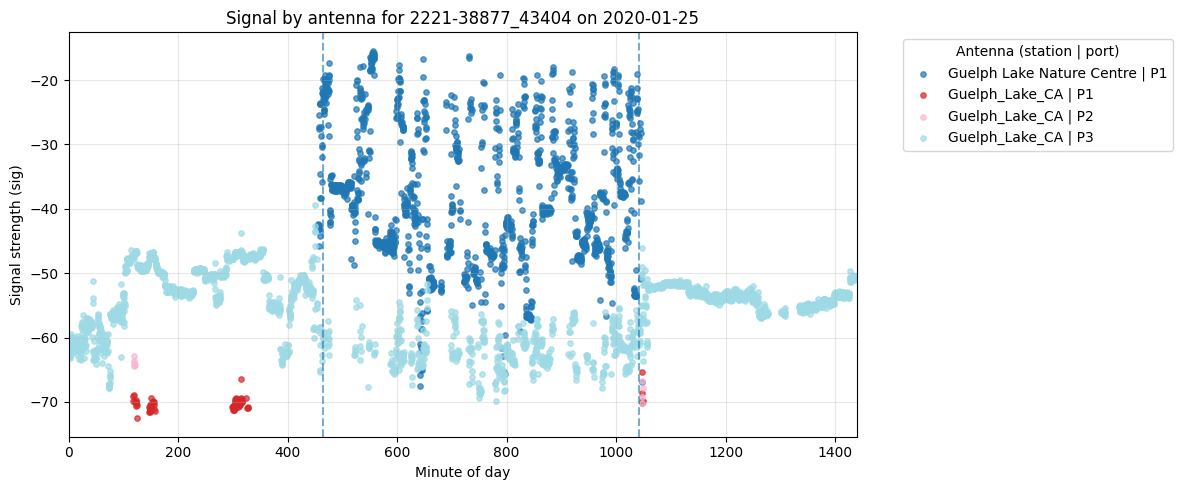

In [15]:
bird = "2221-38877_43404"   # uno real de df['bird_id']
day = "2020-01-25"

plot_day_antennas_full(df, bird, day)

# Testing hipothesis


In [16]:

bird = "2221-38877_43404"
day = pd.to_datetime("2020-01-25").date()

In [17]:
# Filtrar el día y el ave
d = df[(df['bird_id'] == bird) & (df['date'] == day)].copy()

# Crear minuto del día si no existe
if 'minute_of_day' not in d.columns:
    d['minute_of_day'] = d['hour'] * 60 + d['minute']

d['minute_of_day'] = d['hour'] * 60 + d['minute']

In [18]:
# Filtrar el rango de minutos
subset = d[(d['minute_of_day'] >= 1100) & (d['minute_of_day'] <= 1400)]

subset

runID                            ts   tsCorrected      sig  \
1089093  352714594 2020-01-25 18:20:07.333800077  1.579994e+09 -51.8217   
1089095  352714594 2020-01-25 18:20:26.625499964  1.579994e+09 -51.7356   
1089097  352714594 2020-01-25 18:20:45.926300049  1.579994e+09 -51.8100   
1089099  352714594 2020-01-25 18:21:05.227900028  1.579994e+09 -51.7623   
1089101  352714594 2020-01-25 18:21:24.527600050  1.579994e+09 -51.5052   
...            ...                           ...           ...      ...   
1090671  352714641 2020-01-25 23:19:35.053200006  1.580012e+09 -53.3048   
1090673  352714641 2020-01-25 23:19:54.352900028  1.580012e+09 -53.1551   
1090675  352714641 2020-01-25 23:20:13.652499914  1.580012e+09 -53.3702   
1090677  352714641 2020-01-25 23:20:32.951999903  1.580012e+09 -53.0043   
1090679  352714641 2020-01-25 23:20:52.251800060  1.580012e+09 -53.6496   

           sigsd    noise    freq  freqsd  motusTagID ambigID  ...  \
1089093   2.2341 -69.7238  3.4900  0.0025     43404.0     NaN  ...   
1089095   9.9856 -69.1219  3.4920  0.0075     43404.0     NaN  ...   
1089097   0.3777 -69.1692  3.4895  0.0048     43404.0     NaN  ...   
1089099   4.0420 -69.7851  3.4870  0.0034     43404.0     NaN  ...   
1089101   6.5834 -69.4074  3.4905  0.0053     43404.0     NaN  ...   
...          ...      ...     ...     ...         ...     ...  ...   
1090671  11.9666 -67.1158  3.4910  0.0020     43404.0     NaN  ...   
1090673   6.7682 -67.0253  3.4855  0.0087     43404.0     NaN  ...   
1090675   6.7402 -66.7350  3.4897  0.0086     43404.0     NaN  ...   
1090677   4.4648 -66.6027  3.4928  0.0125     43404.0     NaN  ...   
1090679  17.9225 -66.9531  3.4900  0.0041     43404.0     NaN  ...   

         BandNumber  Wing  Fat  Mass Lost  Isotope_value  captureDate  \
1089093  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1089095  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1089097  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1089099  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1089101  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
...             ...   ...  ...   ...  ...            ...          ...   
1090671  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1090673  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1090675  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1090677  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   
1090679  2221-38877    74    3  20.5    0    -155.487588   2020-01-24   

        capture.yday           bird_id  minute_of_day  
1089093         24.0  2221-38877_43404           1100  
1089095         24.0  2221-38877_43404           1100  
1089097         24.0  2221-38877_43404           1100  
1089099         24.0  2221-38877_43404           1101  
1089101         24.0  2221-38877_43404           1101  
...              ...               ...            ...  
1090671         24.0  2221-38877_43404           1399  
1090673         24.0  2221-38877_43404           1399  
1090675         24.0  2221-38877_43404           1400  
1090677         24.0  2221-38877_43404           1400  
1090679         24.0  2221-38877_43404           1400  

[725 rows x 52 columns]

In [19]:
subset[['ts', 'minute_of_day', 'sig', 'port', 'motusFilter', 'noise', 'sigsd', 'freq', 'freqsd']]


ts  minute_of_day      sig port  \
1089093 2020-01-25 18:20:07.333800077           1100 -51.8217    3   
1089095 2020-01-25 18:20:26.625499964           1100 -51.7356    3   
1089097 2020-01-25 18:20:45.926300049           1100 -51.8100    3   
1089099 2020-01-25 18:21:05.227900028           1101 -51.7623    3   
1089101 2020-01-25 18:21:24.527600050           1101 -51.5052    3   
...                               ...            ...      ...  ...   
1090671 2020-01-25 23:19:35.053200006           1399 -53.3048    3   
1090673 2020-01-25 23:19:54.352900028           1399 -53.1551    3   
1090675 2020-01-25 23:20:13.652499914           1400 -53.3702    3   
1090677 2020-01-25 23:20:32.951999903           1400 -53.0043    3   
1090679 2020-01-25 23:20:52.251800060           1400 -53.6496    3   

         motusFilter    noise    sigsd    freq  freqsd  
1089093          1.0 -69.7238   2.2341  3.4900  0.0025  
1089095          1.0 -69.1219   9.9856  3.4920  0.0075  
1089097          1.0 -69.1692   0.3777  3.4895  0.0048  
1089099          1.0 -69.7851   4.0420  3.4870  0.0034  
1089101          1.0 -69.4074   6.5834  3.4905  0.0053  
...              ...      ...      ...     ...     ...  
1090671          1.0 -67.1158  11.9666  3.4910  0.0020  
1090673          1.0 -67.0253   6.7682  3.4855  0.0087  
1090675          1.0 -66.7350   6.7402  3.4897  0.0086  
1090677          1.0 -66.6027   4.4648  3.4928  0.0125  
1090679          1.0 -66.9531  17.9225  3.4900  0.0041  

[725 rows x 9 columns]

In [20]:
df = df.sort_values(['bird_id', 'date', 'ts'])

# Morbey-style transformation: sqrt(|Δsig|)
df['dsig'] = df.groupby(['bird_id', 'date'])['sig'].diff()          # sig_i - sig_{i-1}
df['abs_dsig'] = df['dsig'].abs()
df['sqrt_abs_dsig'] = np.sqrt(df['abs_dsig'])

In [21]:
df = df.sort_values(['bird_id', 'date', 'recvDeployName', 'port', 'ts'])
df['dsig'] = (
    df.groupby(['bird_id', 'date', 'recvDeployName', 'port'])['sig']
      .diff()
)
df['abs_dsig'] = df['dsig'].abs()
df['sqrt_abs_dsig'] = np.sqrt(df['abs_dsig'])

In [22]:
def plot_day_activity_morbey(df, bird_id, day, show_sun=True):
    """
    Plot Morbey-style activity metric (sqrt(|Δsig|)) for one bird-day.
    Color = antenna (station | port), like in plot_day_antennas_full.
    """
    day = pd.to_datetime(day).date()

    d = df[(df['bird_id'] == bird_id) & (df['date'] == day)].copy()
    if d.empty:
        print("No detections for this bird on this date.")
        return

    if 'minute_of_day' not in d.columns:
        d['minute_of_day'] = d['hour'] * 60 + d['minute']

    # antenna id like before
    d['antenna_id'] = (
        d['recvDeployName'].astype(str)
        + " | P" + d['port'].astype(int).astype(str)
    )

    # we need the transformed metric
    if 'sqrt_abs_dsig' not in d.columns:
        raise ValueError("Column 'sqrt_abs_dsig' not found. "
                         "Run the Morbey transformation on df first.")

    antennas = sorted(d['antenna_id'].dropna().unique())
    cmap = plt.cm.get_cmap('tab20', len(antennas))

    plt.figure(figsize=(12, 5))

    for i, ant in enumerate(antennas):
        sub = d[d['antenna_id'] == ant]
        plt.scatter(
            sub['minute_of_day'],
            sub['sqrt_abs_dsig'],
            s=15,
            alpha=0.7,
            label=ant,
            color=cmap(i)
        )

    # optional sunrise/sunset lines (same logic as before)
    if show_sun:
        try:
            sunrise = pd.to_datetime(d['sunrise'].iloc[0])
            sunset  = pd.to_datetime(d['sunset'].iloc[0])
            sr_min = sunrise.hour * 60 + sunrise.minute
            ss_min = sunset.hour * 60 + sunset.minute
            plt.axvline(sr_min, linestyle='--', alpha=0.6)
            plt.axvline(ss_min, linestyle='--', alpha=0.6)
        except Exception as e:
            print("Could not add sunrise/sunset lines:", e)

    plt.xlim(0, 1440)
    plt.xlabel("Minute of day")
    plt.ylabel("Activity metric  sqrt(|Δsig|)")
    plt.title(f"Mor b e y-style activity for {bird_id} on {day}")
    plt.legend(title="Antenna (station | port)",
               bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

C:\Users\jorge\AppData\Local\Temp\ipykernel_18616\2256181156.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(antennas))


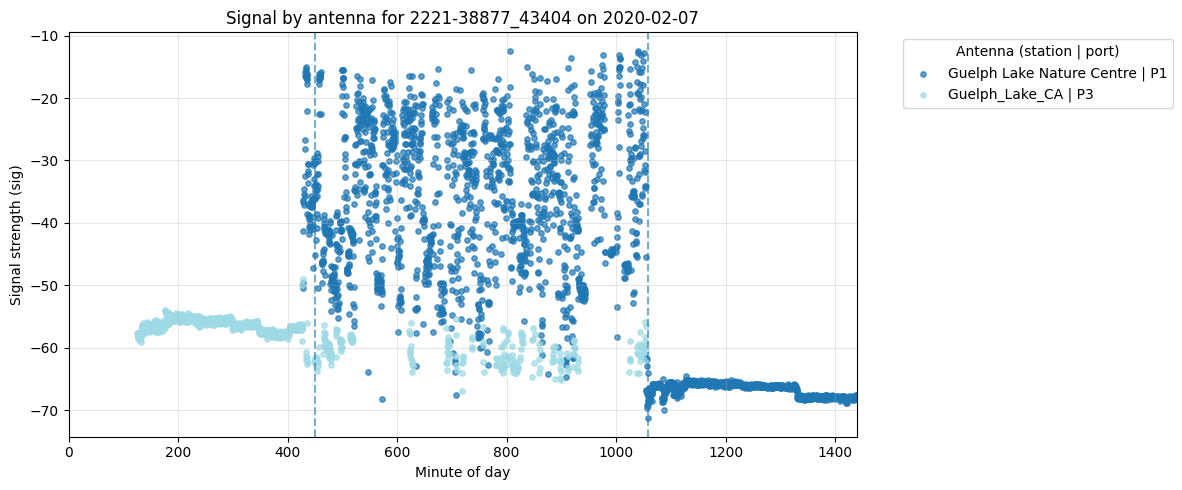

C:\Users\jorge\AppData\Local\Temp\ipykernel_18616\2956559972.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(antennas))


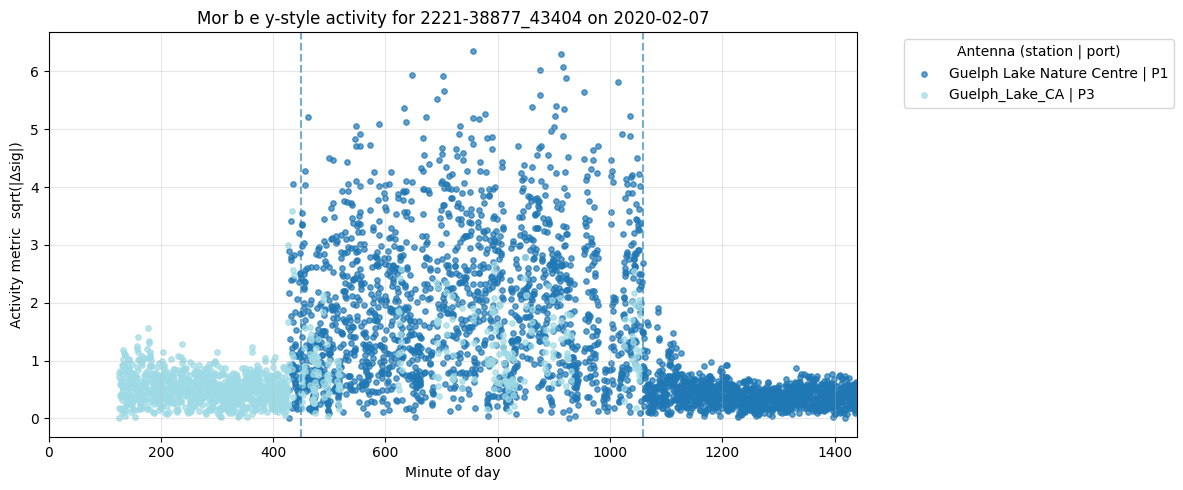

In [67]:
bird = "2221-38877_43404"
day = "2020-02-07"


# Make sure you already ran the transformation on df before this
plot_day_antennas_full(df, bird, day)         # raw sig
plot_day_activity_morbey(df, bird, day)       # sqrt(|Δsig|)

Actividad compuesta

In [24]:
def spectrogram_activity_condensed(df, bird_id, day):
    day = pd.to_datetime(day).date()
    d = df[(df['bird_id']==bird_id) & (df['date']==day)].copy()
    if d.empty:
        print("No detections.")
        return

    # Needs activity metric
    if 'sqrt_abs_dsig' not in d.columns:
        raise ValueError("Run Morbey transformation first.")

    # Aggregate per minute
    agg = (
        d.groupby('minute_of_day')
         .agg(
             activity=('sqrt_abs_dsig', 'median'),
             density=('sqrt_abs_dsig', 'count'),
         )
         .reset_index()
    )

    plt.figure(figsize=(14, 5))

    plt.scatter(
        agg['minute_of_day'],
        agg['activity'],
        c=agg['density'],
        cmap='viridis',
        s=agg['density'] * 4,
        alpha=0.7
    )

    plt.colorbar(label="Detection density (across all antennas)")
    plt.xlabel("Minute of day")
    plt.ylabel("Activity level (sqrt(|Δsig|))")
    plt.title(f"Condensed Activity Spectrogram – {bird_id} on {day}")
    plt.grid(alpha=0.3)
    plt.show()

In [25]:
def spectrogram_freq_condensed(df, bird_id, day, metric='freqsd'):
    day = pd.to_datetime(day).date()
    d = df[(df['bird_id']==bird_id) & (df['date']==day)].copy()
    if d.empty:
        print("No detections.")
        return

    if metric not in d.columns:
        raise ValueError(f"{metric} not found in dataframe")

    agg = (
        d.groupby('minute_of_day')
         .agg(
             value=(metric, 'median'),
             density=(metric, 'count')
         )
         .reset_index()
    )

    plt.figure(figsize=(14, 5))

    plt.scatter(
        agg['minute_of_day'],
        agg['value'],
        c=agg['density'],
        cmap='plasma',
        s=agg['density'] * 4,
        alpha=0.7
    )

    plt.colorbar(label="Detection density (across all antennas)")
    plt.xlabel("Minute of day")
    plt.ylabel(metric)
    plt.title(f"Condensed {metric}-based Spectrogram – {bird_id} on {day}")
    plt.grid(alpha=0.3)
    plt.show()

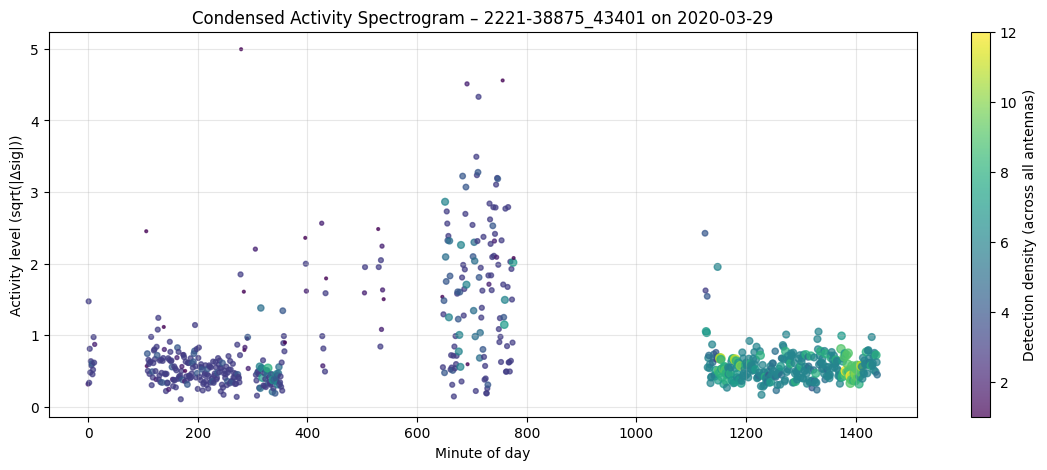

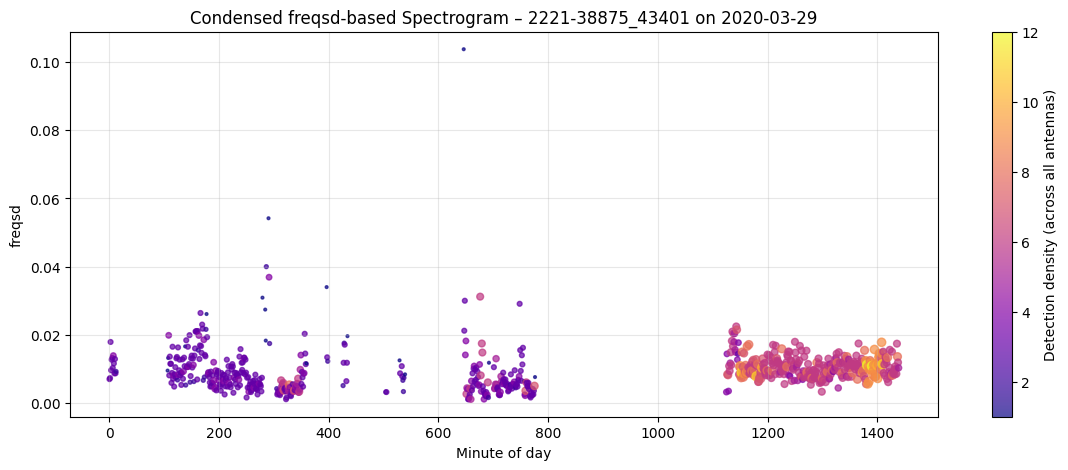

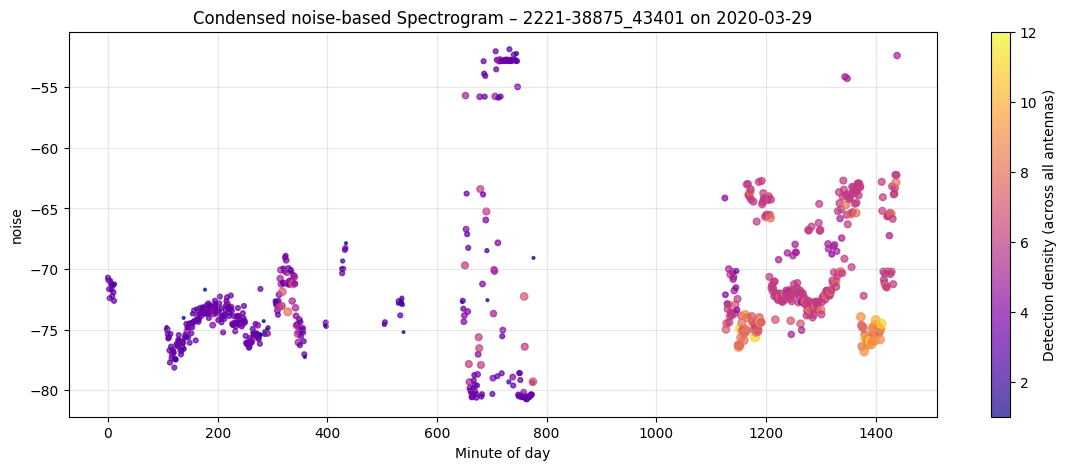

In [26]:
bird = "2221-38875_43401"
day  = "2020-03-29"

spectrogram_activity_condensed(df, bird, day)
spectrogram_freq_condensed(df, bird, day, metric='freqsd')
spectrogram_freq_condensed(df, bird, day, metric='noise')

In [50]:
id_date_pairs

bird_id        date
350746   2221-38875_43401  2020-01-17
352092   2221-38875_43401  2020-01-18
353654   2221-38875_43401  2020-01-19
355235   2221-38875_43401  2020-01-20
356590   2221-38875_43401  2020-01-21
...                   ...         ...
4490750        UNK2_43376  2020-03-27
4523671        UNK2_43376  2020-03-28
4553469        UNK2_43376  2020-03-29
4578023        UNK2_43376  2020-03-30
795426         UNK2_43376  2020-04-01

[2946 rows x 2 columns]

In [125]:
bird = "2221-38882_43406"
day = pd.to_datetime("2020-02-19").date()

In [126]:
d = df[(df['bird_id'] == bird) & (df['date'] == day)].copy()

# Asegurar minute_of_day
d['minute_of_day'] = d['hour'] * 60 + d['minute']

# Ordenar y calcular Δsig
d = d.sort_values('ts')
d['dsig'] = d['sig'].diff().abs()
d['sqrt_abs_dsig'] = np.sqrt(d['dsig'])


In [127]:
d['minute_of_day'] = d['hour'] * 60 + d['minute']

In [128]:
# Agregar por minuto
agg = (
    d.groupby('minute_of_day')
      .agg(
          activity=('sqrt_abs_dsig', 'median'),
          sig_med=('sig', 'median'),
          freq_mean=('freq', 'mean'),
          freqsd_mean=('freqsd', 'mean'),
          noise_mean=('noise', 'mean'),
          n_dets=('sig', 'count')
      )
      .reset_index()
)


In [129]:
# Crear grilla 0–1439
full = pd.DataFrame({'minute_of_day': np.arange(1440)})

# Merge y fill 0
merged = full.merge(agg, on='minute_of_day', how='left')
merged = merged.fillna(0)

In [130]:
merged

minute_of_day  activity  sig_med  freq_mean  freqsd_mean  noise_mean  \
0                 0  2.759845 -57.8641   3.807800      0.00524  -74.881980   
1                 1  2.651566 -57.8542   3.804760      0.01224  -74.491060   
2                 2  2.669605 -61.3034   3.877950      0.01190  -74.440117   
3                 3  1.080694 -57.7658   3.803840      0.00748  -74.392280   
4                 4  0.632218 -57.9526   3.825986      0.00880  -74.747529   
...             ...       ...      ...        ...          ...         ...   
1435           1435  0.000000   0.0000   0.000000      0.00000    0.000000   
1436           1436  0.000000   0.0000   0.000000      0.00000    0.000000   
1437           1437  0.000000   0.0000   0.000000      0.00000    0.000000   
1438           1438  0.000000   0.0000   0.000000      0.00000    0.000000   
1439           1439  0.000000   0.0000   0.000000      0.00000    0.000000   

      n_dets  
0        5.0  
1        5.0  
2        6.0  
3        5.0  
4        7.0  
...      ...  
1435     0.0  
1436     0.0  
1437     0.0  
1438     0.0  
1439     0.0  

[1440 rows x 7 columns]

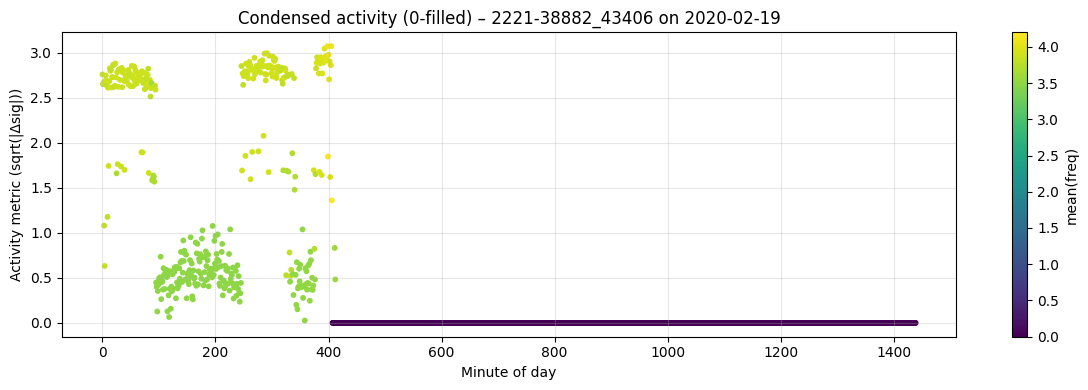

In [131]:
plt.figure(figsize=(12,4))
sc = plt.scatter(
    merged['minute_of_day'],
    merged['activity'],
    c=merged['freq_mean'],
    cmap='viridis',
    s=10
)
plt.colorbar(sc, label='mean(freq)')
plt.xlabel("Minute of day")
plt.ylabel("Activity metric (sqrt(|Δsig|))")
plt.title(f"Condensed activity (0-filled) – {bird} on {day}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [68]:
merged.head(20)

minute_of_day  activity  sig_med  freq_mean  freqsd_mean  noise_mean  \
0               0       0.0      0.0        0.0          0.0         0.0   
1               1       0.0      0.0        0.0          0.0         0.0   
2               2       0.0      0.0        0.0          0.0         0.0   
3               3       0.0      0.0        0.0          0.0         0.0   
4               4       0.0      0.0        0.0          0.0         0.0   
5               5       0.0      0.0        0.0          0.0         0.0   
6               6       0.0      0.0        0.0          0.0         0.0   
7               7       0.0      0.0        0.0          0.0         0.0   
8               8       0.0      0.0        0.0          0.0         0.0   
9               9       0.0      0.0        0.0          0.0         0.0   
10             10       0.0      0.0        0.0          0.0         0.0   
11             11       0.0      0.0        0.0          0.0         0.0   
12             12       0.0      0.0        0.0          0.0         0.0   
13             13       0.0      0.0        0.0          0.0         0.0   
14             14       0.0      0.0        0.0          0.0         0.0   
15             15       0.0      0.0        0.0          0.0         0.0   
16             16       0.0      0.0        0.0          0.0         0.0   
17             17       0.0      0.0        0.0          0.0         0.0   
18             18       0.0      0.0        0.0          0.0         0.0   
19             19       0.0      0.0        0.0          0.0         0.0   

    n_dets  
0      0.0  
1      0.0  
2      0.0  
3      0.0  
4      0.0  
5      0.0  
6      0.0  
7      0.0  
8      0.0  
9      0.0  
10     0.0  
11     0.0  
12     0.0  
13     0.0  
14     0.0  
15     0.0  
16     0.0  
17     0.0  
18     0.0  
19     0.0

In [71]:
import numpy as np
from scipy.io import wavfile

In [72]:
def merged_to_audio(merged, wav_path,
                    duration_sec=60,  # 60 s = 24 min/s
                    sample_rate=16000,
                    column='activity'):
    """
    Convierte un día condensado (merged) en un WAV mono.
    column: qué métrica usar como amplitud (activity, sig_med, etc.)
    """

    # 1) Extraer la serie de actividad (1440 puntos)
    x = merged[column].values.astype(float)

    # 2) Normalizar para que quede en [-1, 1]
    #    (evita saturación al convertir a int16)
    if np.nanmax(np.abs(x)) > 0:
        x = x - np.nanmedian(x)
        x = x / (np.nanmax(np.abs(x)) + 1e-9)
    else:
        x = np.zeros_like(x)

    # 3) Tiempo en "minutos" y en segundos de audio
    t_minutes = merged['minute_of_day'].values.astype(float)  # 0..1439
    n_samples = int(duration_sec * sample_rate)
    t_audio = np.linspace(0, duration_sec, n_samples)

    # Mapear minutos -> segundos (lineal)
    # 0 min -> 0 s ; 1440 min -> duration_sec
    t_minutes_norm = t_minutes / t_minutes.max() * duration_sec

    # 4) Interpolar amplitud sobre la malla de audio
    audio_float = np.interp(t_audio, t_minutes_norm, x)

    # 5) Convertir a int16 para WAV
    audio_int16 = np.int16(np.clip(audio_float, -1, 1) * 32767)

    # 6) Guardar WAV
    wavfile.write(wav_path, sample_rate, audio_int16)

    return sample_rate, audio_float

In [73]:
wav_path = f"audio_{bird}_{day}.wav"
sr, audio_float = merged_to_audio(merged, wav_path)
print("Guardado:", wav_path, "sample_rate:", sr)


Guardado: audio_2221-38877_43404_2020-02-07.wav sample_rate: 16000


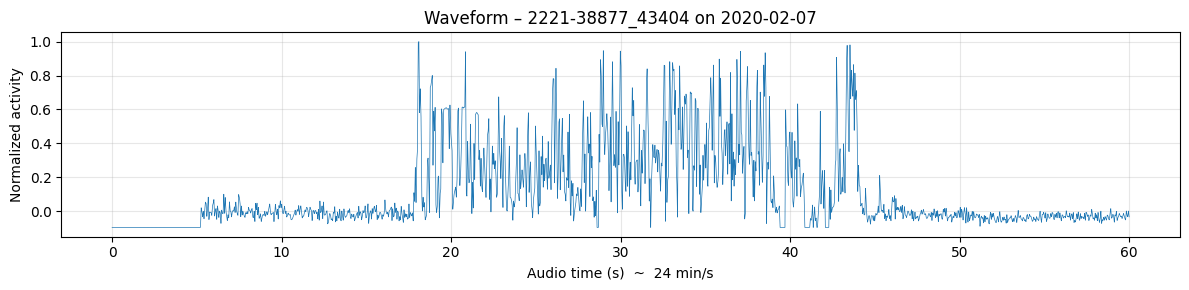

In [74]:
duration_sec = 60
t_audio = np.linspace(0, duration_sec, len(audio_float))

plt.figure(figsize=(12, 3))
plt.plot(t_audio, audio_float, linewidth=0.5)
plt.xlabel("Audio time (s)  ~  24 min/s")
plt.ylabel("Normalized activity")
plt.title(f"Waveform – {bird} on {day}")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

D:\Sparrows\.venv\lib\site-packages\matplotlib\axes\_axes.py:8283: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


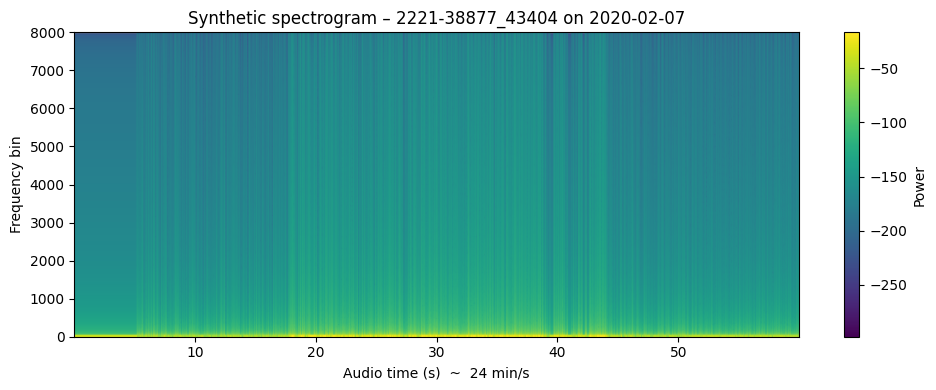

In [75]:
plt.figure(figsize=(10, 4))
plt.specgram(audio_float, NFFT=512, Fs=sr, noverlap=256, cmap='viridis')
plt.xlabel("Audio time (s)  ~  24 min/s")
plt.ylabel("Frequency bin")
plt.title(f"Synthetic spectrogram – {bird} on {day}")
plt.colorbar(label="Power")
plt.tight_layout()
plt.show()

In [77]:
from IPython.display import Audio

In [79]:
Audio(data=audio_float, rate=sr)

In [80]:
from scipy.io import wavfile

In [81]:
def merged_to_tone_audio(merged, wav_path,
                         duration_sec=60,
                         sample_rate=16000,
                         column='activity',
                         carrier_freq=440):
    """
    Sonificación: la serie (column) se usa como envolvente de un tono senoidal.
    Más actividad => tono más fuerte.
    """

    # 1) Serie por minuto
    x = merged[column].values.astype(float)
    x = np.nan_to_num(x, nan=0.0)

    # 2) Normalizar envolvente a [0, 1]
    if np.nanmax(x) > 0:
        x = x / (np.nanmax(x) + 1e-9)
    else:
        x = np.zeros_like(x)

    # 3) Tiempo de audio
    n_samples = int(duration_sec * sample_rate)
    t_audio = np.linspace(0, duration_sec, n_samples)

    # 4) Interpolar envolvente (minuto -> tiempo audio)
    t_minutes = merged['minute_of_day'].values.astype(float)
    t_minutes_norm = t_minutes / t_minutes.max() * duration_sec
    env = np.interp(t_audio, t_minutes_norm, x)  # [0,1]

    # 5) Tono portador (audible)
    carrier = np.sin(2 * np.pi * carrier_freq * t_audio)

    # 6) Audio final = envolvente * tono
    audio_float = env * carrier

    # 7) Escalar a int16 para WAV
    audio_int16 = np.int16(np.clip(audio_float, -1, 1) * 32767)

    wavfile.write(wav_path, sample_rate, audio_int16)
    return sample_rate, audio_float

In [82]:
wav_path = f"tone_audio_{bird}_{day}.wav"
sr, audio_float = merged_to_tone_audio(merged, wav_path)

from IPython.display import Audio
Audio(data=audio_float, rate=sr)